In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import warnings
warnings.filterwarnings('ignore')

plt.rcParams['font.sans-serif'] =['SimHei']  #用来正常显示中文标签
plt.rcParams['axes.unicode_minus'] =False   #用来正常显示负号

from util1 import *

In [2]:
def load_data_from_pickle(file_path, file_name):
    """加载pkl文件"""
    file_path_name = os.path.join(file_path, file_name)
    with open(file_path_name, 'rb') as infile:
        result = pickle.load(infile)
    return result

# 客群信息

In [3]:
# # 基本信息
# entids_baseinfo = ibdp.get_group_data_dt_v4(default_type='v2')
# # 特征宽表
# features_data1 = ibdp.get_vars_widetable()
# features_data2 = ibdp.get_bond_valuation_widetable()
# features_data3 = ibdp.get_vars_rel_by()
# # 特征说明
# vars_info,vars_dict = ibdp.get_vars_info()
# vars_info_reason = ibdp.get_vars_reason()

In [4]:
# vars_info.to_excel(os.path.join(in_dict['RESULT_PATH'],'vars_info.xlsx'),index=False)

In [5]:
vars_info_reason = pd.read_excel('vars_info_reason.xlsx')
vars_info = pd.read_excel('vars_info.xlsx')

In [6]:
# vars_info_reason.to_excel(os.path.join(in_dict['RESULT_PATH'],'vars_info_reason.xlsx'),index=False)

In [7]:
vars_dict = load_data_from_pickle('./', 'vars_dict.pkl')

In [8]:
# save_data_to_pickle(vars_dict,in_dict['RESULT_PATH'],'vars_dict.pkl')

In [99]:
in_dict = {'target':'is_default',
           'obser_datepoint':{'train_good':['20180630','20190630','20200630'],
                              'train_bad':['20180630','20190630','20200630'],
                             },
           'default_obser_period':{'train':[20180630,20190630,20200630,20210630],
               'test':[20180630,20190630,20200630,20210630],
              },
           'index_id':'S_INFO_COMPCODE',
           'extra_col':['S_INFO_COMPCODE','S_INFO_COMPNAME', 'is_cbond', 'is_ashare', 
                       'EntDefaultFirstDate', 'data_dt'],
#            'RESULT_PATH':r'E:\knowlenge\xm\bondriskmodel\report_rf_v4',
           'RESULT_PATH':r'D:\公司\知因智慧\项目\北京银行\汇报文件\交付文件\report_rf_v4\report',
           'sample_cutoff':{
                        'test_cutoff': 0.3,
                        'random_state':125
                    },
           'features_select_thresold':{
               'corr_thresold':0.9,
               'iv_thresold':0.02,
               'psi_thresold':0.05,
               'missing_thresold':0.9,
               
           },
           'woe_delete_features':vars_info_reason[vars_info_reason['阈值'].isna()]['指标英文名称'].tolist()
           ,
        'random_param': {
                'max_depth': 4,
                'min_child_weight':1,
                'subsample': 0.9,
                'colsample_bytree': 0.9,
                'n_estimators': 250 # 80
                ,'class_weight':'balanced'
                ,'random_state':206
                ,'ccp_alpha':0.03
                ,'min_samples_split':8
                }
           ,
           'sample_ratio':{'2018':10,'2019':15,'2020':20,'random_state':180}
           ,
               'algorithm_type':'RF'
           ,
           
          }
features_all = vars_info['指标英文名称'].tolist()
print(len(features_all))

141


In [10]:
# DataALL = pd.merge(entids_baseinfo,features_data1,on=['S_INFO_COMPCODE','S_INFO_COMPNAME','data_dt','is_cbond','is_ashare'],how='left')\
#             .merge(features_data2,on=['S_INFO_COMPCODE','S_INFO_COMPNAME','data_dt'],how='left')\
#             .merge(features_data3,on=['S_INFO_COMPCODE','S_INFO_COMPNAME','data_dt'],how='left')

In [11]:
data = pd.read_excel('DataALL.xlsx')

In [12]:
# data.to_excel(os.path.join(in_dict['RESULT_PATH'],'DataALL.xlsx'),index=False)

In [13]:
data['data_dt'] = data['data_dt'].astype(str)

## 样本抽样

In [14]:
def sample_split_step(data,in_dict):
    """数据集划分，训练集、测试集、时间外验证集"""
    
    df_in_good = data[data['data_dt'].isin(in_dict['obser_datepoint']['train_good'])]
    df_in_good = df_in_good[df_in_good[in_dict['target']]==0]
    df_in_bad = data[data['data_dt'].isin(in_dict['obser_datepoint']['train_bad'])]
    df_in_bad = df_in_bad[df_in_bad[in_dict['target']]==1]

    
    # 剔除不在表现期间的违约样本
    df_in_bad_01 = df_in_bad[(df_in_bad['EntDefaultFirstDate']>in_dict['default_obser_period']['train'][0])&(df_in_bad['EntDefaultFirstDate']<in_dict['default_obser_period']['train'][1])]
    df_in_bad_02 = df_in_bad[(df_in_bad['EntDefaultFirstDate']>in_dict['default_obser_period']['train'][1])&(df_in_bad['EntDefaultFirstDate']<in_dict['default_obser_period']['train'][2])]
    df_in_bad_03 = df_in_bad[(df_in_bad['EntDefaultFirstDate']>in_dict['default_obser_period']['train'][2])&(df_in_bad['EntDefaultFirstDate']<in_dict['default_obser_period']['train'][3])]
    df_in_bad = pd.concat([df_in_bad_01,df_in_bad_02,df_in_bad_03])
    
    # 好客户抽样
    df_in_good_01 = df_in_good[df_in_good['data_dt']==in_dict['obser_datepoint']['train_good'][0]]
    df_in_good_02 = df_in_good[df_in_good['data_dt']==in_dict['obser_datepoint']['train_good'][1]]
    df_in_good_03 = df_in_good[df_in_good['data_dt']==in_dict['obser_datepoint']['train_good'][2]]
    goodbadratio01 = int(len(df_in_good_01)/len(df_in_bad_01))
    goodbadratio02 = int(len(df_in_good_02)/len(df_in_bad_02))
    goodbadratio03 = int(len(df_in_good_03)/len(df_in_bad_03))
    
    ratio_2018 = in_dict['sample_ratio']['2018']/(in_dict['sample_ratio']['2018'] + in_dict['sample_ratio']['2019'] +in_dict['sample_ratio']['2020'])
    ratio_2019 = in_dict['sample_ratio']['2019']/(in_dict['sample_ratio']['2018'] + in_dict['sample_ratio']['2019'] +in_dict['sample_ratio']['2020'])
    ratio_2020 = in_dict['sample_ratio']['2020']/(in_dict['sample_ratio']['2018'] + in_dict['sample_ratio']['2019'] +in_dict['sample_ratio']['2020'])
    df_in_good_01_entids = df_in_good_01.sample(int(len(df_in_good_01)*ratio_2018),random_state=in_dict['sample_ratio']['random_state'])['S_INFO_COMPCODE'].tolist()
    df_in_good_02_emp = df_in_good_02[~df_in_good_02['S_INFO_COMPCODE'].isin(df_in_good_01_entids)]
    
    
    if int(len(df_in_good_02)*ratio_2019) > len(df_in_good_02_emp):
        df_in_good_02_entids = df_in_good_02_emp['S_INFO_COMPCODE'].tolist()
    else:
        df_in_good_02_entids = df_in_good_02_emp.sample(int(len(df_in_good_02)*ratio_2019),random_state=in_dict['sample_ratio']['random_state'])['S_INFO_COMPCODE'].tolist()
    df_in_good_03_emp = df_in_good_03[~((df_in_good_03['S_INFO_COMPCODE'].isin(df_in_good_01_entids))|(df_in_good_03['S_INFO_COMPCODE'].isin(df_in_good_02_entids)))]

    if int(len(df_in_good_03)*ratio_2020) > len(df_in_good_03_emp):
        df_in_good_03_entids =df_in_good_03_emp['S_INFO_COMPCODE'].tolist()
    else:
        df_in_good_03_entids = df_in_good_03_emp.sample(int(len(df_in_good_03)*ratio_2020),random_state=in_dict['sample_ratio']['random_state'])['S_INFO_COMPCODE'].tolist()
    df_in_good_01_sample = df_in_good_01[df_in_good_01['S_INFO_COMPCODE'].isin(df_in_good_01_entids)]
    df_in_good_02_sample = df_in_good_02[df_in_good_02['S_INFO_COMPCODE'].isin(df_in_good_02_entids)]
    df_in_good_03_sample = df_in_good_03[df_in_good_03['S_INFO_COMPCODE'].isin(df_in_good_03_entids)]
    df_in_good_sample = pd.concat([df_in_good_01_sample,df_in_good_02_sample,df_in_good_03_sample])
    
    print(len(df_in_good_01_sample)+len(df_in_bad_01))
    print(len(df_in_good_02_sample)+len(df_in_bad_03))
    print(len(df_in_good_03_sample)+len(df_in_bad_02))
    
    df_in = pd.concat([df_in_good_sample,df_in_bad])
    df_train, df_test, y_train, y_test = train_test_split(df_in, df_in[in_dict['target']], 
                            test_size=in_dict['sample_cutoff']['test_cutoff'], 
                            random_state=in_dict['sample_cutoff']['random_state'])
    
    df_train = df_train[~df_train['S_INFO_COMPCODE'].isin(df_test['S_INFO_COMPCODE'])]
    df_test = df_test[~df_test['S_INFO_COMPCODE'].isin(df_train['S_INFO_COMPCODE'])]
    print(df_train.shape,df_test.shape)
    print('train bad count:{}'.format(df_train[in_dict['target']].sum()))
    print('test bad count:{}'.format(df_test[in_dict['target']].sum()))
    print('train badrate:{:.2%}'.format(df_train[in_dict['target']].sum()/len(df_train)))
    print('test badrate:{:.2%}'.format(df_test[in_dict['target']].sum()/len(df_test)))

    return df_train,df_test

In [15]:
df_train,df_test = sample_split_step(data,in_dict)

997
1485
2131
(3229, 148) (1384, 148)
train bad count:79
test bad count:36
train badrate:2.45%
test badrate:2.60%


In [16]:
df_train['DataSetType'] = 'train'
df_test['DataSetType'] = 'test'
data_ori = pd.concat([df_train,df_test],axis=0)
data_ori.shape

(4613, 149)

# EDA

In [22]:
def create_dict(dat,useless_vars = [],vars_info=None,vars_dict=None):
    """初始化EDA"""
    
    if useless_vars:
        X_col = list(set(dat.columns.tolist()).difference(set(useless_vars)))
    else:
        X_col = list(set(dat.columns.tolist()))

    df = dat[X_col].copy()
#     vars_info,vars_dict = IndBondDataPrepare().get_vars_info()
    vars_info = vars_info[['指标一级分类', '指标二级分类', '指标英文名称', '指标中文名称']]
    vars_info = vars_info[vars_info['指标英文名称'].isin(df.columns)]
    vars_info = pd.merge(vars_info,df.dtypes.reset_index().rename(columns={'index':'指标英文名称',0:'数据类型'}),how='left',on='指标英文名称')
    vars_info['数据类型'] = vars_info['数据类型'].apply(
        lambda x: 'varchar' if x == 'object' else 'float' if x == 'float64' else 'int')
    return vars_info

In [24]:
# 生成字典
var_dict = create_dict(df_train,[],vars_info,vars_dict)

In [25]:
eda_df_train = eda(X = df_train,var_dict=var_dict, useless_vars = [])
eda_df_test = eda(X = df_test,var_dict=var_dict, useless_vars = [])

# 缺失值

In [26]:
df_train_clean ,var_fill_value = process_missing(df_train,var_dict)
df_test_clean = process_missing_assign(df_test,var_fill_value,cols=features_all)

In [27]:
save_data_to_pickle(var_fill_value, file_path=in_dict['RESULT_PATH'], file_name='var_fill_value.pkl')

In [28]:
df_train_clean['DataSetType'] = 'train'
df_test_clean['DataSetType'] = 'test'
data_clean = pd.concat([df_train_clean,df_test_clean],axis=0)
data_clean.shape

(4613, 149)

In [92]:
data_clean.head()

,S_INFO_COMPCODE,S_INFO_COMPNAME,is_cbond,is_ashare,EntDefaultFirstDate,data_dt,is_default,E30000001,E30000002,E30000003,...,E10000040,E10000041,E10000042,E10000043,E10000044,E10000045,E10000046,E10000047,E10000048,DataSetType
11998,660450402,成都市新津城乡建设投资有限责任公司,1,0,NaN,20200630,0,3.5930,0.0953,0.4699,...,0.0,0.0,0.0,0.0,0.0,0.0000,0.0,0.0,0.0,train
12371,XEvW2mqzdV,南京六合经济技术开发集团有限公司,1,0,NaN,20200630,0,-5.0907,-0.4399,0.3806,...,0.0,0.0,-100.0,0.0,0.0,0.0000,0.0,0.0,0.0,train
7116,itwL2Y0ocp,高密市城市建设投资集团有限公司,1,0,NaN,20190630,0,-726.3804,-0.3746,0.3394,...,0.0,-100.0,0.0,0.0,0.0,0.0000,0.0,0.0,0.0,train
1822,SHELU3QyBX,成都市公共交通集团有限公司,1,0,NaN,20180630,0,1.7623,0.0846,0.5897,...,0.0,-75.0,-100.0,0.0,0.0,0.0000,0.0,0.0,0.0,train
10751,16DA69,北京颖泰嘉和生物科技股份有限公司,1,0,NaN,20200630,0,3.3388,0.2039,0.5712,...,0.0,-12.5,100.0,100.0,0.0,-66.6667,0.0,0.0,0.0,train


# 分箱

In [29]:
train_var_bins = get_var_bins(df_train_clean,features_all,in_dict,method = 'qcut')

In [30]:
df_train_clean_bins = binning(df_train_clean,features_all,train_var_bins)
df_test_clean_bins = binning(df_test_clean,features_all,train_var_bins)

In [31]:
df_train_clean_bins['DataSetType'] = 'train'
df_test_clean_bins['DataSetType'] = 'test'
data_clean_bins = pd.concat([df_train_clean_bins,df_test_clean_bins],axis=0)
data_clean_bins.shape

(4613, 149)

In [93]:
data_clean_bins.head()

,S_INFO_COMPCODE,S_INFO_COMPNAME,is_cbond,is_ashare,EntDefaultFirstDate,data_dt,is_default,E30000001,E30000002,E30000003,...,E10000040,E10000041,E10000042,E10000043,E10000044,E10000045,E10000046,E10000047,E10000048,DataSetType
11998,660450402,成都市新津城乡建设投资有限责任公司,1,0,NaN,20200630,0,"(2.938, 3.593]","(0.0513, 0.0953]","(0.436, 0.47]",...,"(-inf, 0.0]","(-25.0, 0.0]","(-33.333, 0.0]","(-33.333, 0.0]","(-100.0, 0.0]","(-100.0, 0.0]","(-50.0, 0.0]","(-100.0, 0.0]","(-66.667, 0.0]",train
12371,XEvW2mqzdV,南京六合经济技术开发集团有限公司,1,0,NaN,20200630,0,"(-10.543, 1.248]","(-0.474, -0.152]","(0.336, 0.388]",...,"(-inf, 0.0]","(-25.0, 0.0]","(-inf, -100.0]","(-33.333, 0.0]","(-100.0, 0.0]","(-100.0, 0.0]","(-50.0, 0.0]","(-100.0, 0.0]","(-66.667, 0.0]",train
7116,itwL2Y0ocp,高密市城市建设投资集团有限公司,1,0,NaN,20190630,0,"(-inf, -55.916]","(-0.474, -0.152]","(0.336, 0.388]",...,"(-inf, 0.0]","(-inf, -100.0]","(-33.333, 0.0]","(-33.333, 0.0]","(-100.0, 0.0]","(-100.0, 0.0]","(-50.0, 0.0]","(-100.0, 0.0]","(-66.667, 0.0]",train
1822,SHELU3QyBX,成都市公共交通集团有限公司,1,0,NaN,20180630,0,"(1.248, 2.081]","(0.0513, 0.0953]","(0.568, 0.591]",...,"(-inf, 0.0]","(-86.865, -50.0]","(-inf, -100.0]","(-33.333, 0.0]","(-100.0, 0.0]","(-100.0, 0.0]","(-50.0, 0.0]","(-100.0, 0.0]","(-66.667, 0.0]",train
10751,16DA69,北京颖泰嘉和生物科技股份有限公司,1,0,NaN,20200630,0,"(2.938, 3.593]","(0.146, 0.288]","(0.568, 0.591]",...,"(-inf, 0.0]","(-25.0, 0.0]","(0.0, 100.0]","(0.0, 129.89]","(-100.0, 0.0]","(-100.0, 0.0]","(-50.0, 0.0]","(-100.0, 0.0]","(-66.667, 0.0]",train


In [94]:
data_clean_bins

,S_INFO_COMPCODE,S_INFO_COMPNAME,is_cbond,is_ashare,EntDefaultFirstDate,data_dt,is_default,E30000001,E30000002,E30000003,...,E10000040,E10000041,E10000042,E10000043,E10000044,E10000045,E10000046,E10000047,E10000048,DataSetType
11998,660450402,成都市新津城乡建设投资有限责任公司,1,0,NaN,20200630,0,"(2.938, 3.593]","(0.0513, 0.0953]","(0.436, 0.47]",...,"(-inf, 0.0]","(-25.0, 0.0]","(-33.333, 0.0]","(-33.333, 0.0]","(-100.0, 0.0]","(-100.0, 0.0]","(-50.0, 0.0]","(-100.0, 0.0]","(-66.667, 0.0]",train
12371,XEvW2mqzdV,南京六合经济技术开发集团有限公司,1,0,NaN,20200630,0,"(-10.543, 1.248]","(-0.474, -0.152]","(0.336, 0.388]",...,"(-inf, 0.0]","(-25.0, 0.0]","(-inf, -100.0]","(-33.333, 0.0]","(-100.0, 0.0]","(-100.0, 0.0]","(-50.0, 0.0]","(-100.0, 0.0]","(-66.667, 0.0]",train
7116,itwL2Y0ocp,高密市城市建设投资集团有限公司,1,0,NaN,20190630,0,"(-inf, -55.916]","(-0.474, -0.152]","(0.336, 0.388]",...,"(-inf, 0.0]","(-inf, -100.0]","(-33.333, 0.0]","(-33.333, 0.0]","(-100.0, 0.0]","(-100.0, 0.0]","(-50.0, 0.0]","(-100.0, 0.0]","(-66.667, 0.0]",train
1822,SHELU3QyBX,成都市公共交通集团有限公司,1,0,NaN,20180630,0,"(1.248, 2.081]","(0.0513, 0.0953]","(0.568, 0.591]",...,"(-inf, 0.0]","(-86.865, -50.0]","(-inf, -100.0]","(-33.333, 0.0]","(-100.0, 0.0]","(-100.0, 0.0]","(-50.0, 0.0]","(-100.0, 0.0]","(-66.667, 0.0]",train
10751,16DA69,北京颖泰嘉和生物科技股份有限公司,1,0,NaN,20200630,0,"(2.938, 3.593]","(0.146, 0.288]","(0.568, 0.591]",...,"(-inf, 0.0]","(-25.0, 0.0]","(0.0, 100.0]","(0.0, 129.89]","(-100.0, 0.0]","(-100.0, 0.0]","(-50.0, 0.0]","(-100.0, 0.0]","(-66.667, 0.0]",train
11268,bIBFtBFUP4,中建三局集团有限公司,1,0,NaN,20200630,0,"(10.065, 47.884]","(0.288, 0.358]","(-inf, 0.194]",...,"(-inf, 0.0]","(27.475, 183.333]","(-100.0, -61.821]","(129.89, inf]","(0.0, 50.0]","(-100.0, 0.0]","(-50.0, 0.0]","(-100.0, 0.0]","(-inf, -66.667]",train
12247,2yWIKpC3zO,临汾市投资集团有限公司,1,0,NaN,20200630,0,"(1.248, 2.081]","(0.146, 0.288]","(0.504, 0.568]",...,"(-inf, 0.0]","(-25.0, 0.0]","(-33.333, 0.0]","(-33.333, 0.0]","(-100.0, 0.0]","(-100.0, 0.0]","(-50.0, 0.0]","(-100.0, 0.0]","(-66.667, 0.0]",train
7479,IQqfpiu6aa,兴义市信恒城市建设投资有限公司,1,0,NaN,20190630,0,"(-55.916, -10.543]","(0.0953, 0.146]","(0.47, 0.504]",...,"(-inf, 0.0]","(-25.0, 0.0]","(-33.333, 0.0]","(-33.333, 0.0]","(-100.0, 0.0]","(-100.0, 0.0]","(-50.0, 0.0]","(-100.0, 0.0]","(-66.667, 0.0]",train
12451,RpbjhaGdmY,中兵投资管理有限责任公司,1,0,NaN,20200630,0,"(1.248, 2.081]","(0.358, 0.988]","(0.706, inf]",...,"(-inf, 0.0]","(-50.0, -25.0]","(-33.333, 0.0]","(-33.333, 0.0]","(-100.0, 0.0]","(100.0, inf]","(-100.0, -50.0]","(-inf, -100.0]","(-66.667, 0.0]",train
3008,RHODylESpq,湖南华侨城文旅投资有限公司,1,0,NaN,20180630,0,"(2.938, 3.593]","(-inf, -0.953]","(0.504, 0.568]",...,"(-inf, 0.0]","(-25.0, 0.0]","(-33.333, 0.0]","(-33.333, 0.0]","(-100.0, 0.0]","(-100.0, 0.0]","(-50.0, 0.0]","(-100.0, 0.0]","(-66.667, 0.0]",train


# PSI

In [32]:
test_psi_dt = psi_df(df_train_clean_bins,df_test_clean_bins,features_all,is_transform_bins=True).rename(columns={'PSI':'test_psi'})

In [33]:
test_psi_dict=  {}
for vars,row in test_psi_dt.iterrows():
    test_psi_dict[row['指标英文名称']] = row['test_psi']

In [95]:
test_psi_dict

{'E30000056': 0.0075,
 'E32000012': 0.0075,
 'E41000011': 0.0071,
 'E41000012': 0.0069,
 'E34000012': 0.0056,
 'E35000014': 0.0055,
 'E10000006': 0.0053,
 'E34000013': 0.0052,
 'E33000001': 0.0051,
 'E34000016': 0.005,
 'E32000014': 0.0049,
 'E30000057': 0.0047,
 'E30000004': 0.0046,
 'E30000041': 0.0043,
 'E10000007': 0.0042,
 'E30000003': 0.0041,
 'E10000029': 0.004,
 'E50000002': 0.0039,
 'E10000041': 0.0039,
 'E33000015': 0.0037,
 'E10000005': 0.0037,
 'E32000013': 0.0036,
 'E41000013': 0.0034,
 'E30000001': 0.0034,
 'E30000055': 0.0033,
 'E30000045': 0.0033,
 'E30000058': 0.0032,
 'E31000052': 0.0032,
 'E34000018': 0.0031,
 'E33000014': 0.0031,
 'E41000010': 0.003,
 'E10000030': 0.003,
 'E31000002': 0.0029,
 'E41000003': 0.0029,
 'E30000054': 0.0029,
 'E41000014': 0.0026,
 'E30000053': 0.0025,
 'E34000017': 0.0025,
 'E50000001': 0.0025,
 'E34000015': 0.0024,
 'E30000048': 0.0024,
 'E30000043': 0.0023,
 'E30000047': 0.0022,
 'E31000001': 0.0022,
 'E30000046': 0.0022,
 'E30000049': 

# IV

In [34]:
woe_dt = get_woe(df_train_clean_bins,features_all,vars_dict) 
# woe_dt.to_excel(os.path.join(in_dict['RESULT_PATH'],'WOE.xlsx'),index=False)

In [98]:
woe_dt['指标英文名称'].nunique()

141

In [35]:
train_iv_dt = iv_df(df_train_clean_bins,features_all,in_dict).rename(columns={'IV':'train_iv'})
test_iv_dt = iv_df(df_test_clean_bins,features_all,in_dict).rename(columns={'IV':'test_iv'})

In [36]:
train_iv_dict=  {}
for vars,row in train_iv_dt.iterrows():
    train_iv_dict[row['指标英文名称']] = row['train_iv']

In [37]:
test_iv_dict=  {}
for vars,row in test_iv_dt.iterrows():
    test_iv_dict[row['指标英文名称']] = row['test_iv']

In [96]:
train_iv_dict

{'E50000001': 2.792037451311491,
 'E41000014': 1.6611293233949544,
 'E20000001': 1.5861817100854214,
 'E41000022': 1.5548527071571308,
 'E10000027': 0.9341376178116754,
 'E10000025': 0.8997818061259656,
 'E10000026': 0.873880437876062,
 'E41000020': 0.804112579727306,
 'E30000053': 0.7767834680315275,
 'E30000001': 0.7677332321902841,
 'E41000007': 0.7244828408416144,
 'E41000012': 0.7166702899650617,
 'E41000006': 0.7150684680163408,
 'E41000008': 0.6614296289688374,
 'E50000002': 0.6493259458959876,
 'E41000013': 0.6283619544060295,
 'E10000038': 0.6202736259766968,
 'E10000028': 0.6043888486932063,
 'E30000004': 0.5516442841151927,
 'E41000019': 0.5395289353184265,
 'E41000011': 0.515553355248376,
 'E41000003': 0.48374472435382354,
 'E41000016': 0.47051361465976477,
 'E41000002': 0.452110730567043,
 'E41000004': 0.42636142290596424,
 'E10000037': 0.3980377581427486,
 'E41000015': 0.3968536713837209,
 'E41000010': 0.3954707957829377,
 'E10000002': 0.3716611269939762,
 'E32000012': 0.

## EDA合并

In [38]:
eda_df_train_merge = pd.merge(eda_df_train,test_psi_dt,on=['指标英文名称'],how='left')\
                        .merge(train_iv_dt,on=['指标英文名称'],how='left')\
                        .merge(test_iv_dt,on=['指标英文名称'],how='left')

In [39]:
# 合并指标阈值
eda_df_train_merge = pd.merge(eda_df_train_merge,vars_info_reason,on='指标英文名称',how='left')

In [40]:
# eda_df_train_merge.to_excel(os.path.join(in_dict['RESULT_PATH'],'EDA.xlsx'),index=False)

# 特征选择

In [41]:
base_select,woe_delete_vars,iv_delete_vars,psi_delete_vars,missing_delete_vars,iv_change_delete_vars = var_base_select(eda_df_train_merge,in_dict)

筛选后的特征数:116


In [42]:
def var_corr_select(df,corr_thresold,ead_df,cols,in_dict):
    
    # 保存相关性矩阵
    corr_df = df[cols].corr()
    # corr_df.to_excel(os.path.join(in_dict['RESULT_PATH'],'corr.xlsx'),index=False)
    
    # IV DataFrame
    iv_df = ead_df[ead_df['指标英文名称'].isin(cols)]
    corr_thresold = in_dict['features_select_thresold']['corr_thresold']
    # IV排序
    high_IV = {k:v for k,v in zip(iv_df['指标英文名称'],iv_df['train_iv'])}
    high_IV_sorted = sorted(high_IV.items(),key=lambda x:x[1],reverse=True)

    #两两间的线性相关性检验
    #1，将候选变量按照IV进行降序排列
    #2，计算第i和第i+1的变量的线性相关系数
    #3，对于系数超过阈值的两个变量，剔除IV较低的一个
    deleted_index = []
    cnt_vars = len(high_IV_sorted)
    # 剔除详情
    delete_detail = []
    for i in range(cnt_vars):
        if i in deleted_index:
            continue
        x1 = high_IV_sorted[i][0]
        for j in range(cnt_vars):
            if i == j or j in deleted_index:
                continue
            y1 = high_IV_sorted[j][0]
#             roh = np.corrcoef(df[x1],df[y1])[0,1]
            roh = corr_df.loc[x1,y1]
            if abs(roh)>corr_thresold:
                x1_IV = high_IV_sorted[i][1]
                y1_IV = high_IV_sorted[j][1]
                
                if x1_IV > y1_IV:
                    deleted_index.append(j)
#                     print(x1,y1,x1_IV,y1_IV,abs(roh))
                    delete_detail.append([x1,y1,x1_IV,y1_IV,roh])
                else:
                    deleted_index.append(i)
                    delete_detail.append([y1,x1,y1_IV,x1_IV,roh])
#                     print(y1,x1,y1_IV,x1_IV,abs(roh))

    var_select_corr = [high_IV_sorted[i][0] for i in range(cnt_vars) if i not in deleted_index]
    # 筛选后的特征
    print('筛选后的特征数:{}'.format(len(var_select_corr)))
    # 删除的特征
    corr_delete_vars = list(set(cols)-set(var_select_corr))
    return var_select_corr,corr_delete_vars,corr_df,delete_detail

In [43]:
corr_select,corr_delete_vars,corr_df,delete_detail = var_corr_select(df=df_train_clean,corr_thresold=0.9,ead_df=eda_df_train_merge,cols=base_select,in_dict=in_dict)

筛选后的特征数:91


In [44]:
delete_detail_df = pd.DataFrame(delete_detail,columns=['保留指标名称','剔除指标名称','保留指标IV','剔除指标IV','相关性系数'])

In [45]:
imp_select,model_importance = var_imp_select(df_train_clean,corr_select,in_dict)

筛选后的特征数:81


In [46]:
imp_select = model_importance[model_importance['importance']>0.005]['variable'].tolist()

In [47]:
imp_delete_vars = list(set(corr_select)-set(imp_select))
len(imp_delete_vars)

51

In [48]:
eda_df_train_merge['是否WOE单调性删除特征'] = eda_df_train_merge['指标英文名称'].isin(woe_delete_vars)
eda_df_train_merge['是否缺失率删除特征'] = eda_df_train_merge['指标英文名称'].isin(missing_delete_vars)
eda_df_train_merge['是否IV删除特征'] = eda_df_train_merge['指标英文名称'].isin(iv_delete_vars)
eda_df_train_merge['是否PSI删除特征'] = eda_df_train_merge['指标英文名称'].isin(psi_delete_vars)
eda_df_train_merge['是否相关性删除特征'] = eda_df_train_merge['指标英文名称'].isin(corr_delete_vars)
eda_df_train_merge['是否IV变化特征删除特征'] = eda_df_train_merge['指标英文名称'].isin(iv_change_delete_vars)
eda_df_train_merge['是否特征重要性删除特征'] = eda_df_train_merge['指标英文名称'].isin(imp_delete_vars)

In [52]:
vars_info['是否入模（中行）'] = vars_info['是否入模（中行）'].astype(str)

## 最终入模指标

In [53]:
by_features_v1 = vars_info[vars_info['是否入模（中行）']=='1']['指标英文名称'].tolist()

In [54]:
artficial_select = [
    'E30000001','E30000002','E30000003','E30000004','E30000005','E31000001','E33000001','E35000014'
    ,'E10000028','E10000031','E10000002','E10000008'
    ,'E50000001','E50000002'
    ,'E20000001','E20000002'
    ,'E40000001','E40000002','E40000005','E40000006','E40000010','E40000011','E40000012'
    ,'E41000014','E41000022','E41000007','E41000013','E41000001'
]
#'E10000025','E10000030'--------->'E10000028','E10000031',
print(len(artficial_select))

28


In [55]:
features_select = artficial_select
print('入模特征数量:{}'.format(len(features_select)))

入模特征数量:28


# 模型训练

In [56]:
model,train,test,params_df,model_importance = model_train(features_select,df_train_clean,df_test_clean,in_dict)

(4613, 149)
训练集坏客户占比:2.45%
测试集坏客户占比:2.60%


In [57]:
train.head()

,S_INFO_COMPCODE,S_INFO_COMPNAME,is_cbond,is_ashare,EntDefaultFirstDate,data_dt,is_default,E30000001,E30000002,E30000003,...,E10000041,E10000042,E10000043,E10000044,E10000045,E10000046,E10000047,E10000048,DataSetType,pred
11998,660450402,成都市新津城乡建设投资有限责任公司,1,0,NaN,20200630,0,3.5930,0.0953,0.4699,...,0.0,0.0,0.0,0.0,0.0000,0.0,0.0,0.0,train,0.230491
12371,XEvW2mqzdV,南京六合经济技术开发集团有限公司,1,0,NaN,20200630,0,-5.0907,-0.4399,0.3806,...,0.0,-100.0,0.0,0.0,0.0000,0.0,0.0,0.0,train,0.155914
7116,itwL2Y0ocp,高密市城市建设投资集团有限公司,1,0,NaN,20190630,0,-726.3804,-0.3746,0.3394,...,-100.0,0.0,0.0,0.0,0.0000,0.0,0.0,0.0,train,0.181378
1822,SHELU3QyBX,成都市公共交通集团有限公司,1,0,NaN,20180630,0,1.7623,0.0846,0.5897,...,-75.0,-100.0,0.0,0.0,0.0000,0.0,0.0,0.0,train,0.284512
10751,16DA69,北京颖泰嘉和生物科技股份有限公司,1,0,NaN,20200630,0,3.3388,0.2039,0.5712,...,-12.5,100.0,100.0,0.0,-66.6667,0.0,0.0,0.0,train,0.815271


In [58]:
imp_dict=  {}
for vars,row in model_importance.iterrows():
    imp_dict[row['variable']] = round(row['importance'],4)

In [59]:
train['DataSetType'] = 'train'
test['DataSetType'] = 'test'
data_pred = pd.concat([train,test],axis=0)
# data_pred['pred_bins'] = data_pred['pred_bins'].astype(str)
data_pred.shape

(4613, 150)

          ## 混淆矩阵 ##
实际 \ 预测     正常          违约          
正常          2827        323         
违约          9           70          

          ## 混淆矩阵 ##
实际 \ 预测     正常          违约          
正常          1223        125         
违约          6           30          



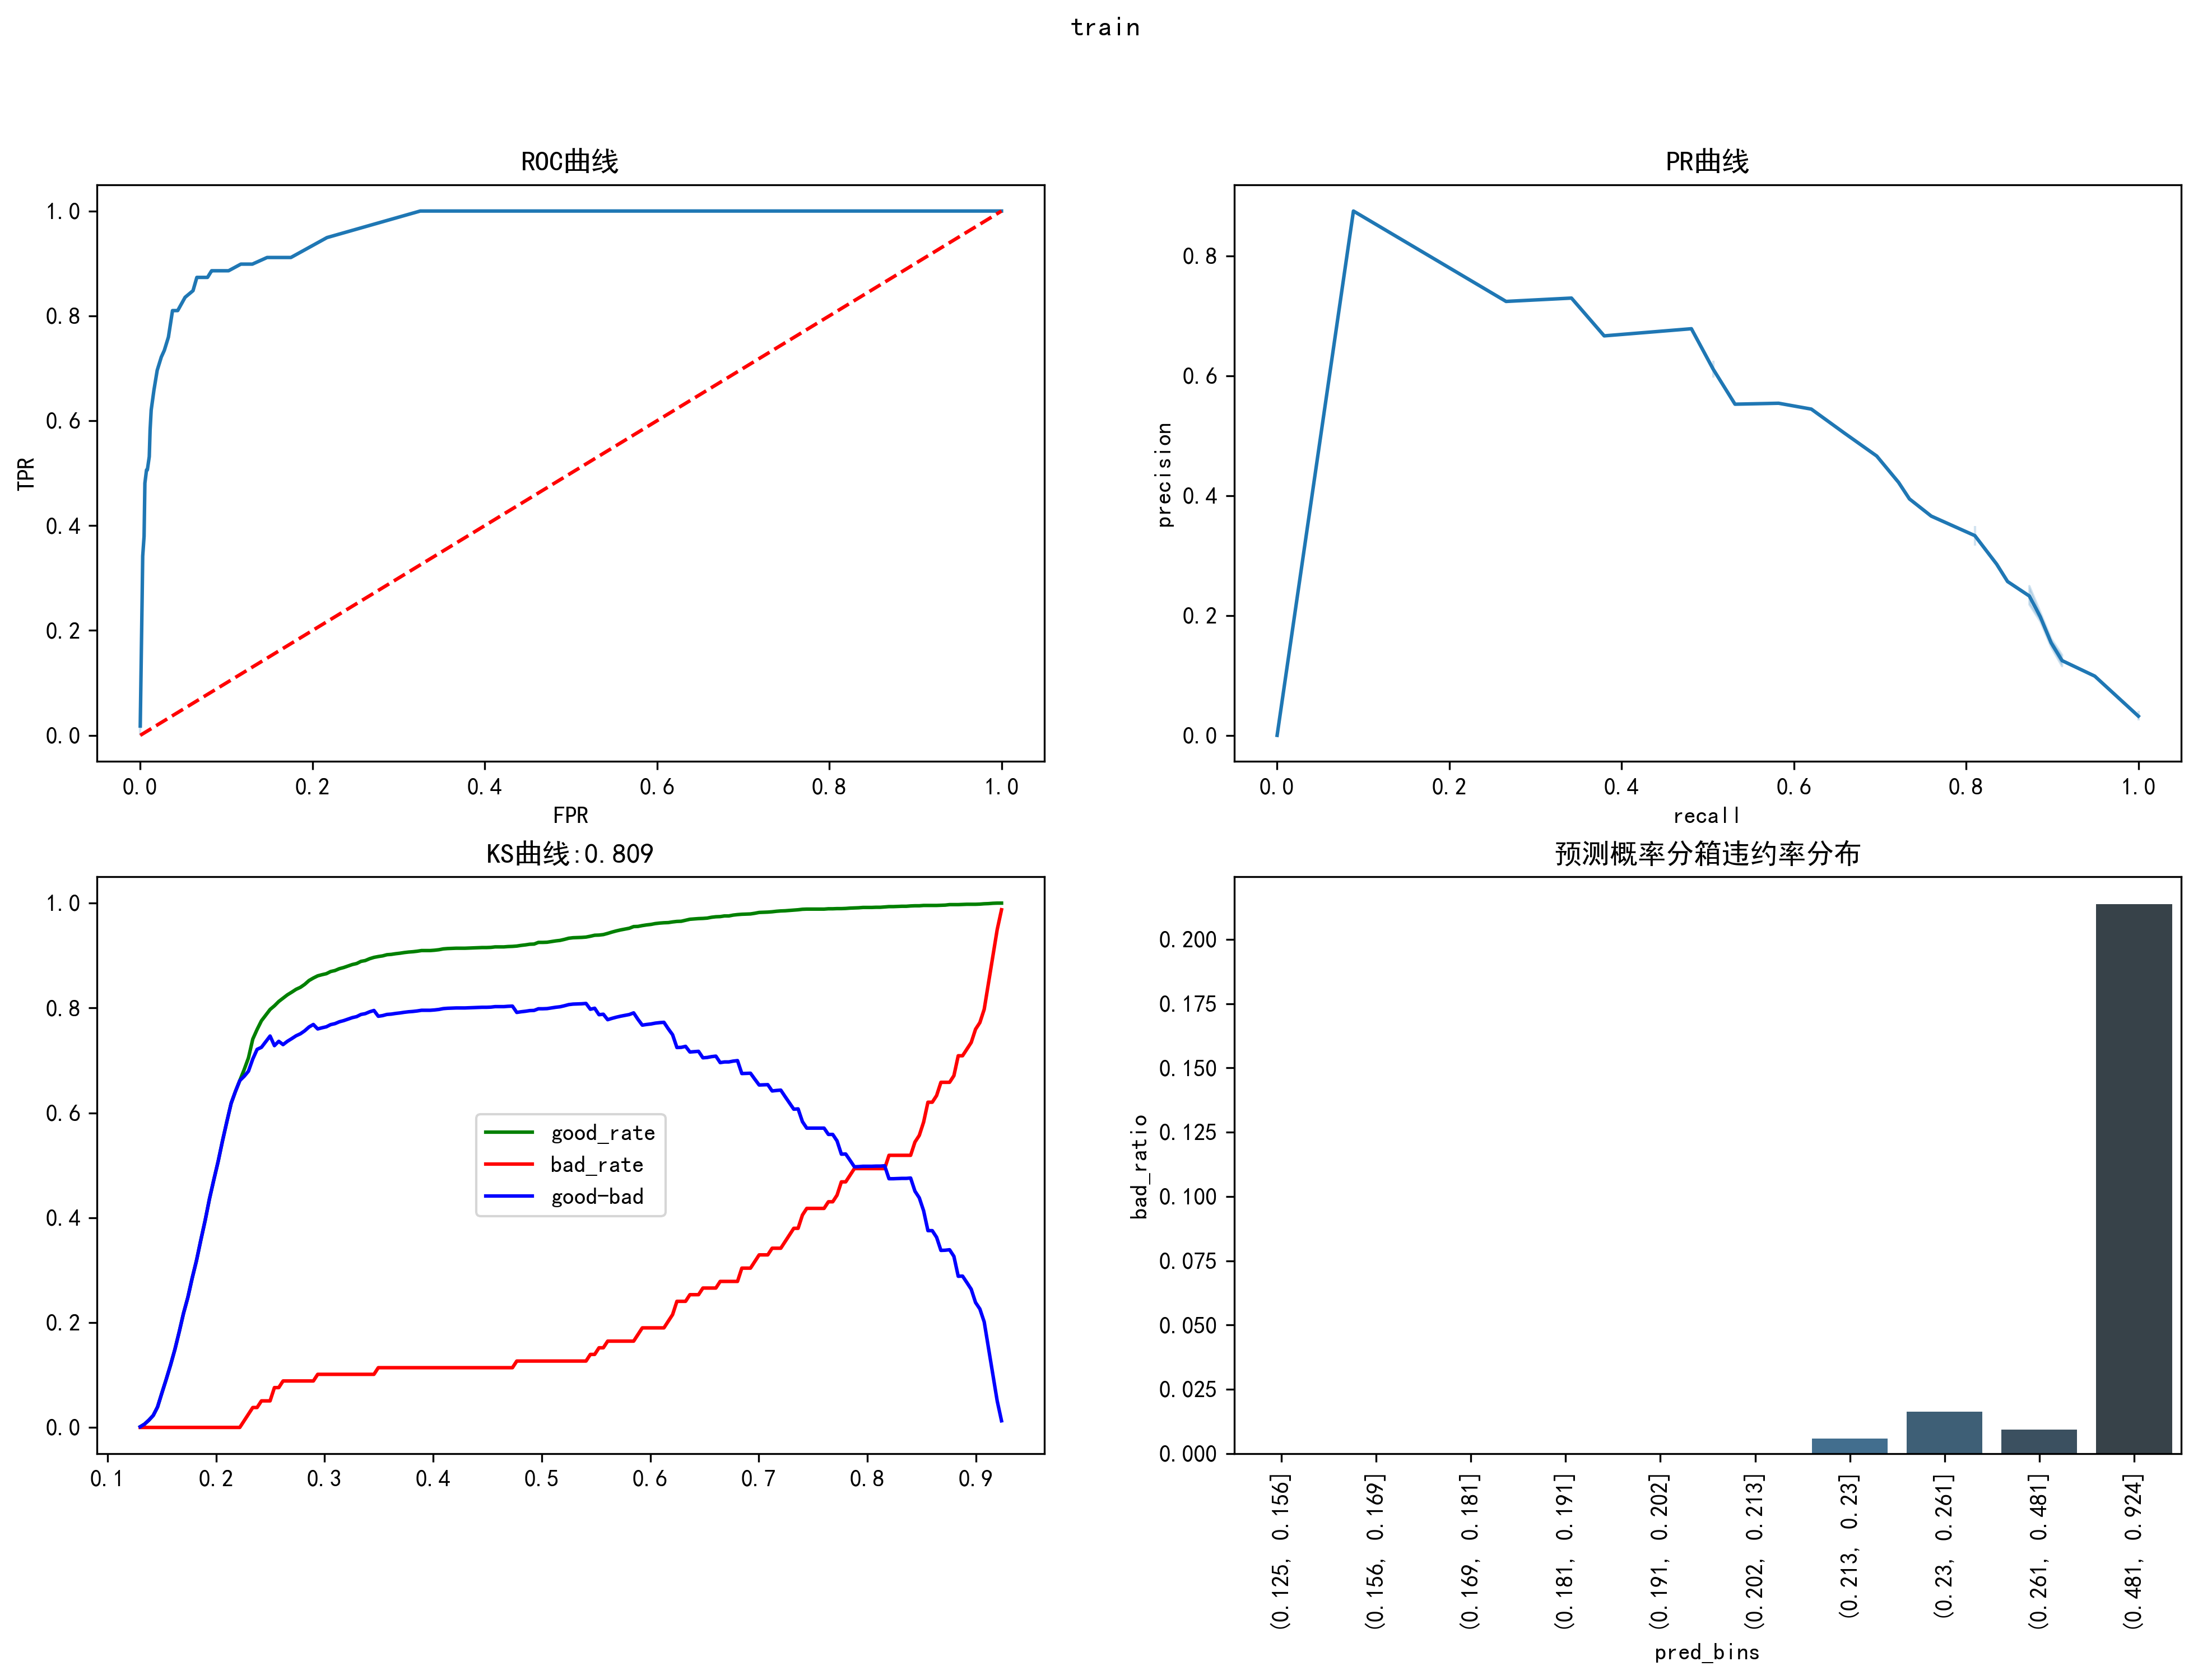

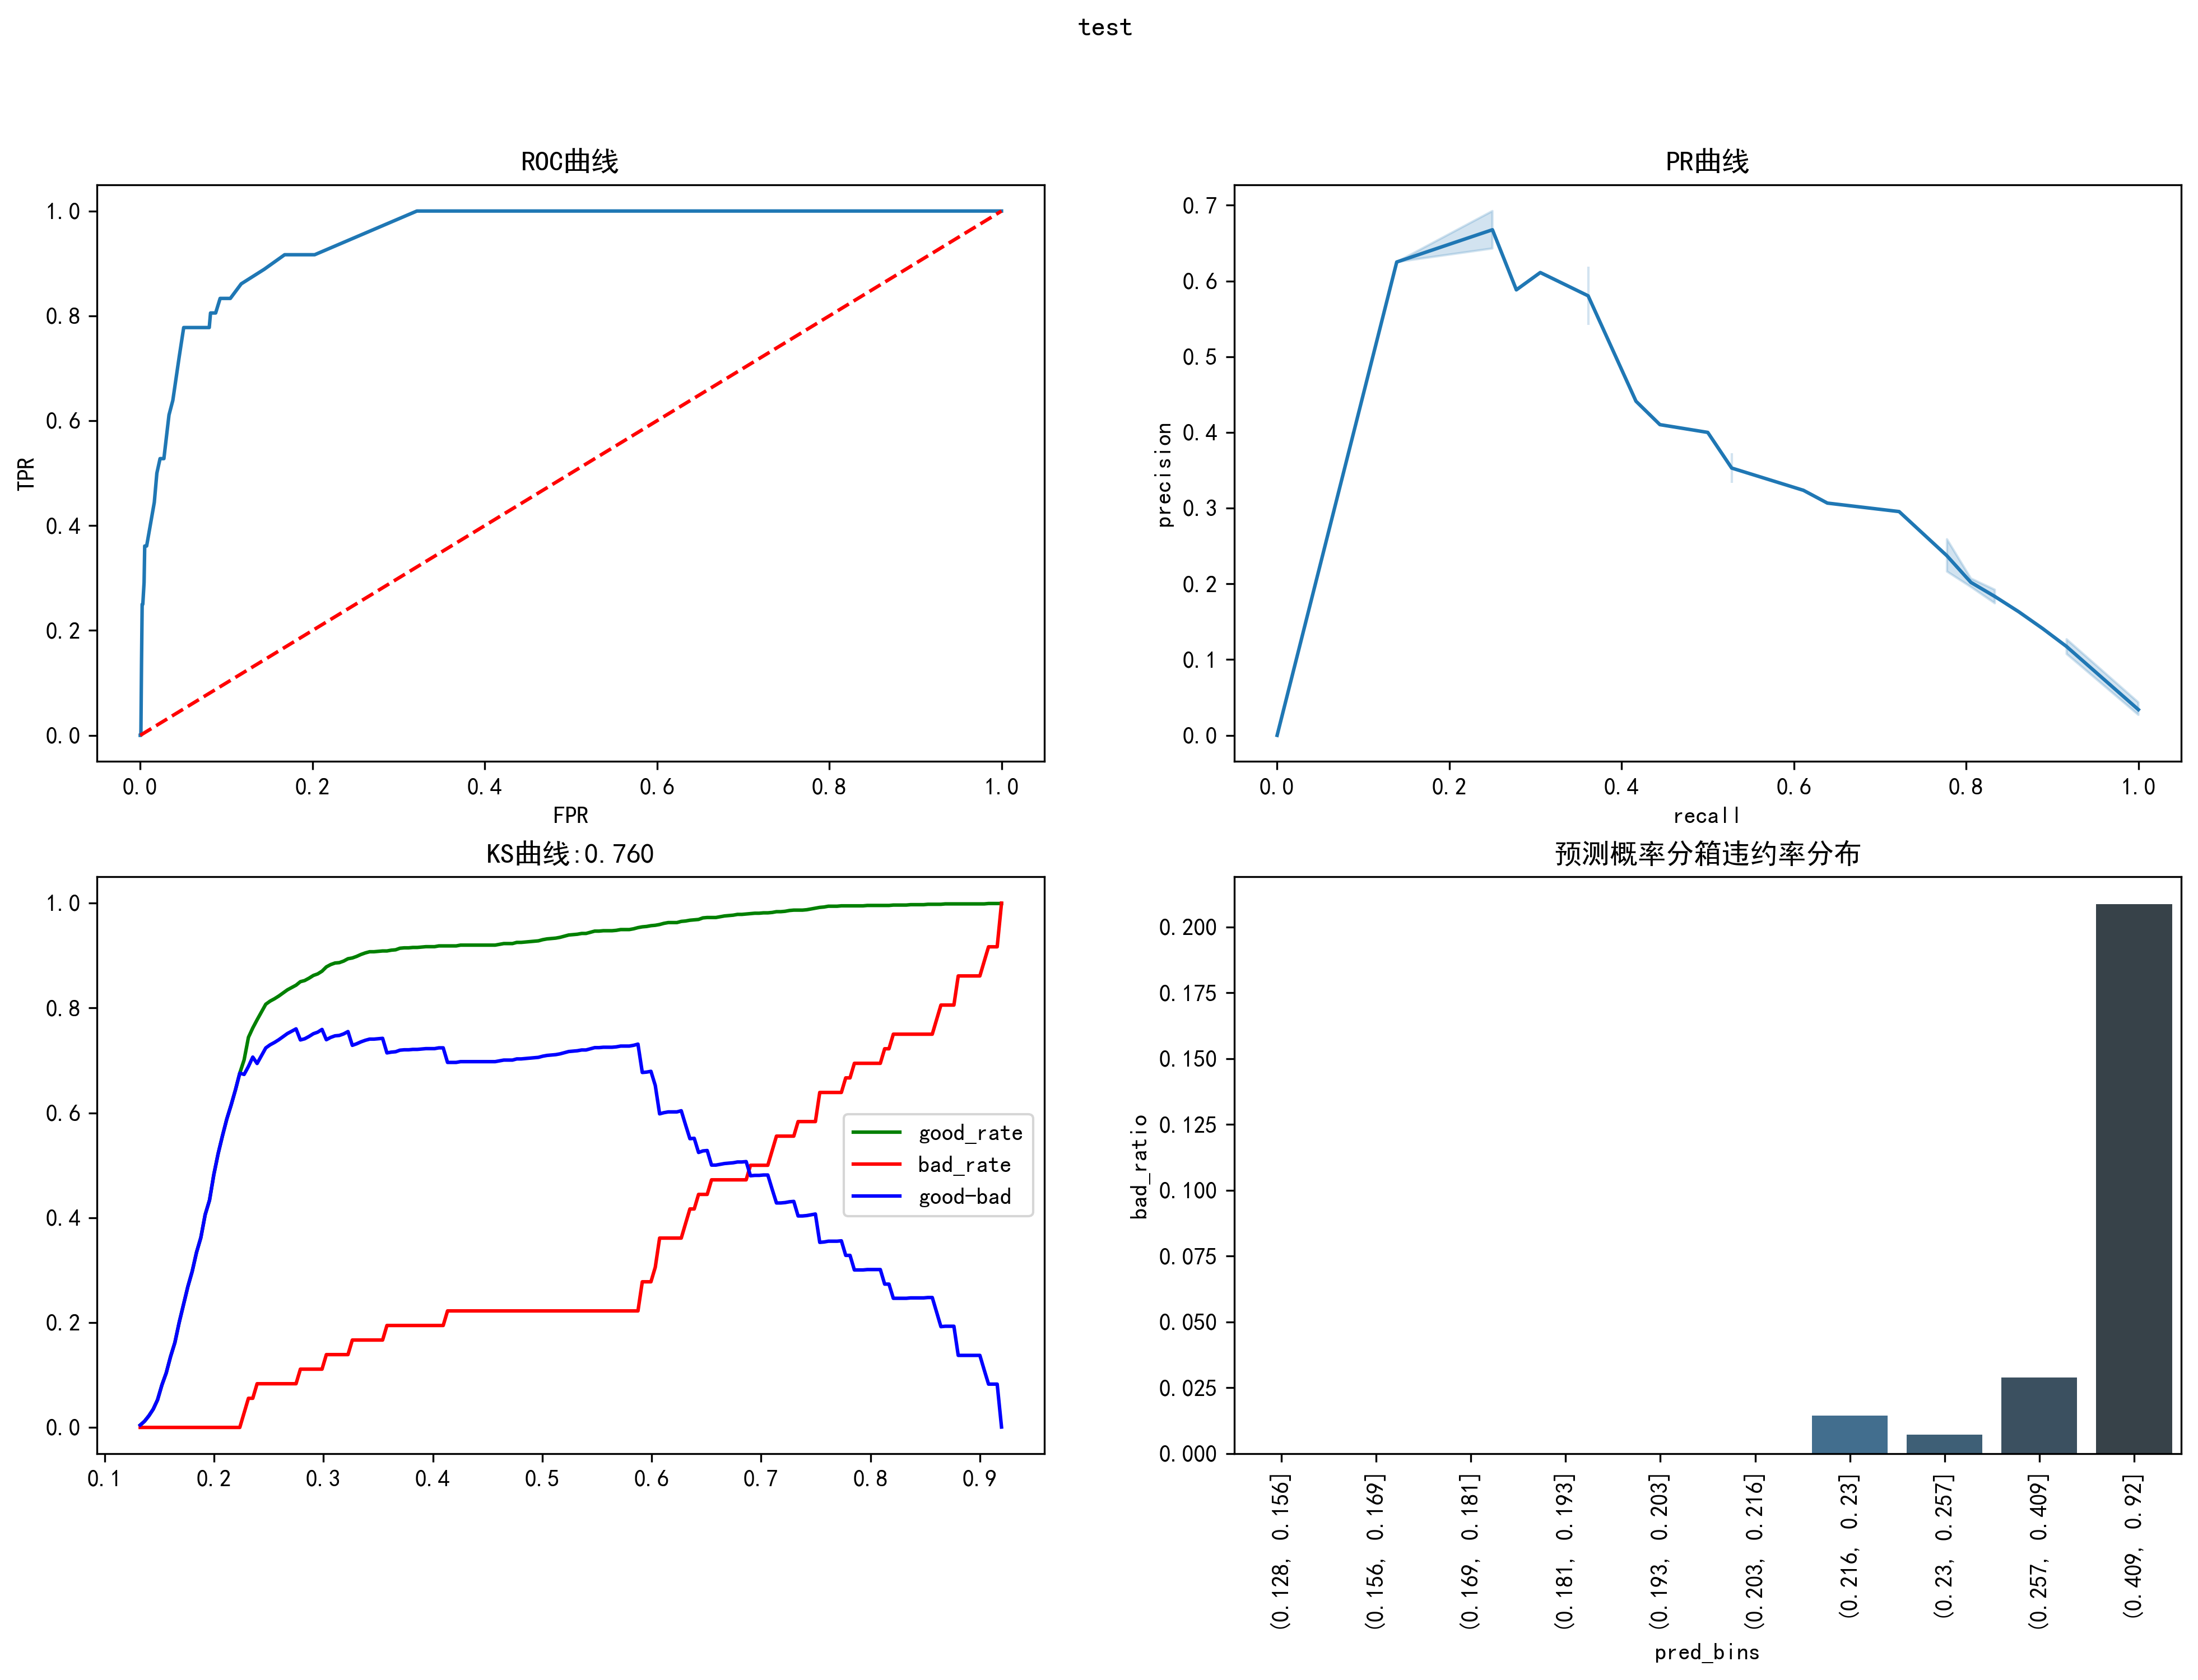

In [60]:
best_pred_class_threshold,metric_df,metircs_plot_dict,train_recall_precision_dt,test_recall_precision_dt = model_mertics(train,test,in_dict)

In [61]:
best_pred_class_threshold

0.4081632653061224

In [62]:
train_recall_precision_dt.to_excel(os.path.join(in_dict['RESULT_PATH'],'train_recall_precision_dt.xlsx'),index=False)

In [63]:
test_recall_precision_dt.to_excel(os.path.join(in_dict['RESULT_PATH'],'test_recall_precision_dt.xlsx'),index=False)

In [64]:
metric_df['total'] = [train[in_dict['target']].count(),test[in_dict['target']].count()]
metric_df['bad'] = [train[in_dict['target']].sum(),test[in_dict['target']].sum()]
metric_df['bad_ratio'] = metric_df['bad']/metric_df['total']
metric_df

,KS,Recall,Precision,F1,AUC,DataType,obser_datepoint,total,bad,bad_ratio
0,0.809291,0.886076,0.178117,0.296610,0.963552,train,"['20180630', '20190630', '20200630']",3229,79,0.024466
0,0.765002,0.833333,0.193548,0.314136,0.948566,test,"['20180630', '20190630', '20200630']",1384,36,0.026012


In [65]:
best_pred_class_threshold

0.4081632653061224

In [66]:
data_ori2 = pd.merge(data_ori,data_pred[['S_INFO_COMPCODE','pred','DataSetType']],on=['S_INFO_COMPCODE','DataSetType'],how='left')

In [67]:
data_ori2['pred_class'] =data_ori2['pred'].map(lambda x:1 if x>best_pred_class_threshold else 0)

## 概率分布

In [68]:
def pred_distr(data):
    pred_dt = data.copy()
    pred_dt['pred_bins'] = pd.qcut(pred_dt['pred'],20)
    pred_dt_bins = pred_dt.groupby(['pred_bins'])['is_default'].agg({'样本数':'count','坏样本数':'sum'})
    pred_dt_bins['好样本数'] = pred_dt_bins['样本数'] - pred_dt_bins['坏样本数']
    pred_dt_bins['坏样本占比'] = pred_dt_bins['坏样本数']/pred_dt_bins['样本数']
    pred_dt_bins = pred_dt_bins.reset_index()
    pred_dt_bins = pred_dt_bins.rename(columns={'pred_bins':'预测概率区间'})
    return pred_dt_bins

pred_distribute_dt  = pred_distr(data_ori2)
pred_distribute_dt.to_excel(os.path.join(in_dict['RESULT_PATH'],'11 模型预测概率分布.xlsx'),index=False)

## 概率PSI

In [69]:
def psi_score(data):
    psi_dt = data.copy()
    psi_dt['pred_bins'] = pd.qcut(psi_dt['pred'],10)

    train_data = psi_dt[psi_dt['DataSetType']=='train']
    train_data_bins = train_data.groupby(['pred_bins'])['is_default'].agg({'样本数':'count'})
    train_data_bins = train_data_bins.reset_index()
    train_data_bins = train_data_bins.rename(columns={'pred_bins':'预测概率区间','样本数':'训练集样本数'})
    train_data_bins['预测概率区间'] = train_data_bins['预测概率区间'].astype(str)

    test_data = psi_dt[psi_dt['DataSetType']=='test']
    test_data_bins = test_data.groupby(['pred_bins'])['is_default'].agg({'样本数':'count'})
    test_data_bins = test_data_bins.reset_index()
    test_data_bins = test_data_bins.rename(columns={'pred_bins':'预测概率区间','样本数':'测试集样本数'})
    test_data_bins['预测概率区间'] = test_data_bins['预测概率区间'].astype(str)

    all_data_bins = pd.merge(train_data_bins,test_data_bins,how='left',on='预测概率区间')

    all_data_bins['训练集各组个数占比'] = all_data_bins['训练集样本数']/all_data_bins['训练集样本数'].sum()
    all_data_bins['测试集各组个数占比'] = all_data_bins['测试集样本数']/all_data_bins['测试集样本数'].sum()

    all_data_bins['psi'] = (all_data_bins['训练集各组个数占比']-all_data_bins['测试集各组个数占比']) * np.log10(all_data_bins['训练集各组个数占比']/all_data_bins['测试集各组个数占比'])
    all_data_bins['psi'] = all_data_bins['psi'].map(lambda x:round(x,4))
    all_data_bins = all_data_bins.replace([np.inf,-np.inf],0)
    return all_data_bins

In [70]:
psi_dt_res = psi_score(data_ori2)

In [71]:
psi_dt_res.to_excel(os.path.join(in_dict['RESULT_PATH'],'12 模型PSI分布.xlsx'),index=False)

## 概率决策表

In [72]:
def decision_cal(data):
    decision_dt = data.copy()
    decision_dt['pred_bins'] = pd.qcut(decision_dt['pred'],20)
    decision_dt_bins = decision_dt.groupby(['pred_bins'])['is_default'].agg({'总':'count','坏':'sum'})
    decision_dt_bins['好'] = decision_dt_bins['总'] - decision_dt_bins['坏']
    decision_dt_bins = decision_dt_bins.reset_index()

    decision_dt_bins['好累计'] = decision_dt_bins['好'].cumsum()
    decision_dt_bins['坏累计'] = decision_dt_bins['坏'].cumsum()
    decision_dt_bins['总累计'] = decision_dt_bins['总'].cumsum()

    decision_dt_bins['阈值'] = decision_dt_bins['pred_bins'].map(lambda x:str(x).split(',')[1][:-1].strip()).astype(float)
    decision_dt_bins['通过率'] = decision_dt_bins['总累计']/decision_dt_bins['总'].sum()

    decision_dt_bins['每段违约率'] = decision_dt_bins['坏']/decision_dt_bins['总']
    decision_dt_bins['累计违约率'] = decision_dt_bins['坏累计']/decision_dt_bins['总累计']


    good_mans_ratio_list = []
    bad_recog_ratio_list = []
    pred_class_thresold_list = decision_dt_bins['阈值'].tolist()
    for thresold in pred_class_thresold_list:
        decision_dt_emp = decision_dt.copy()
        decision_dt_emp['pred_class'] = (decision_dt_emp['pred'] > thresold).astype(int)
        decision_dt_emp2 = decision_dt_emp[decision_dt_emp['is_default']==0]
        if (len(decision_dt_emp2[decision_dt_emp2['pred_class']==1]) == 0) or (len(decision_dt_emp2) == 0):
            good_mans_ratio = 0
            good_mans_ratio_list.append(good_mans_ratio)
        else:
            good_mans_ratio = round(len(decision_dt_emp2[decision_dt_emp2['pred_class']==1])/len(decision_dt_emp2),4)
            good_mans_ratio_list.append(good_mans_ratio)

        decision_dt_emp3 = decision_dt_emp[decision_dt_emp['is_default']==1]
        if (len(decision_dt_emp3[decision_dt_emp3['pred_class']==1]) == 0) or (len(decision_dt_emp3) == 0):
            bad_recog_ratio = 0
            bad_recog_ratio_list.append(bad_recog_ratio)
        else:
            bad_recog_ratio = round(len(decision_dt_emp3[decision_dt_emp3['pred_class']==1])/len(decision_dt_emp3),4)
            bad_recog_ratio_list.append(bad_recog_ratio)


    decision_dt_bins_t2= pd.DataFrame({'阈值':pred_class_thresold_list,'好客户误杀率':good_mans_ratio_list,'坏客户识别率':bad_recog_ratio_list})

    decision_dt_bins_all = pd.merge(decision_dt_bins,decision_dt_bins_t2,how='left',on=['阈值'])

    decision_dt_bins_all = decision_dt_bins_all.rename(columns={'pred_bins':'预测概率区间'})

    decision_dt_bins_all = decision_dt_bins_all[['预测概率区间', '总',  '好','坏', '好累计', '坏累计', '总累计', '通过率', '每段违约率',
           '累计违约率', '好客户误杀率', '坏客户识别率']]
    return decision_dt_bins_all

In [73]:
decision_dt_bins_all = decision_cal(data_ori2).to_excel(os.path.join(in_dict['RESULT_PATH'],'13 模型预测概率决策表.xlsx'),index=False)

# report

In [74]:
eda_df_train_merge['是否入模'] = (eda_df_train_merge['指标英文名称'].isin(features_select)).astype(int)
eda_df_train_merge['中行是否入模'] = (eda_df_train_merge['指标英文名称'].isin(by_features_v1)).astype(int)

In [75]:
globle_params_df = pd.DataFrame({'Globle_Params':in_dict}).reset_index().rename(columns={'index':'Globle_Params_Name','Globle_Params':'Globle_Params_Value'})
for col in globle_params_df.columns:
    globle_params_df[col] = globle_params_df[col].astype(str)

In [76]:
eda_df_train_merge.columns

Index(['指标英文名称', '指标一级分类', '指标二级分类', '指标中文名称_x', '数据类型', '非空个数', '总个数',
       '缺失值个数', '缺失率', '唯一值个数', 'mean', 'std', 'median', 'min', 'max', 'p01',
       'p05', 'p10', 'p25', 'p75', 'p90', 'p95', 'p99', 'N_categories',
       '1st类别', '2nd类别', '3rd类别', 'test_psi', 'train_iv', 'test_iv',
       '指标中文名称_y', '阈值', '逻辑符号', '归因输出内容', '是否WOE单调性删除特征', '是否缺失率删除特征',
       '是否IV删除特征', '是否PSI删除特征', '是否相关性删除特征', '是否IV变化特征删除特征', '是否特征重要性删除特征',
       '是否入模', '中行是否入模'],
      dtype='object')

In [77]:
del_cols = ['1st类别','2nd类别', '3rd类别','test_out_psi','test_out_iv','阈值', '逻辑符号', '归因输出内容'
                                              ,'是否WOE单调性删除特征','是否IV变化特征删除特征','N_categories']

In [78]:
for col in del_cols:
    if col in eda_df_train_merge.columns:
        eda_df_train_merge = eda_df_train_merge.drop([col],axis=1)

In [79]:
eda_df_train_merge.columns

Index(['指标英文名称', '指标一级分类', '指标二级分类', '指标中文名称_x', '数据类型', '非空个数', '总个数',
       '缺失值个数', '缺失率', '唯一值个数', 'mean', 'std', 'median', 'min', 'max', 'p01',
       'p05', 'p10', 'p25', 'p75', 'p90', 'p95', 'p99', 'test_psi', 'train_iv',
       'test_iv', '指标中文名称_y', '是否缺失率删除特征', '是否IV删除特征', '是否PSI删除特征',
       '是否相关性删除特征', '是否特征重要性删除特征', '是否入模', '中行是否入模'],
      dtype='object')

## 保存结果

In [80]:
# 01 EDA
eda_df_train_merge.to_excel(os.path.join(in_dict['RESULT_PATH'],'01 EDA.xlsx'),index=False)

In [81]:
# 02 MissingFillValue
pd.DataFrame(pd.Series(var_fill_value)).reset_index().rename(columns={'index':'variable',0:'fill_value'}).to_excel(os.path.join(in_dict['RESULT_PATH'],'02 MissingFillValue.xlsx'),index=False)

In [82]:
# 03 WOE
woe_dt[woe_dt['指标英文名称'].isin(features_select)].to_excel(os.path.join(in_dict['RESULT_PATH'],'03 WOE.xlsx'),index=False)

In [83]:
# 04 ModelParams
params_df.to_excel(os.path.join(in_dict['RESULT_PATH'],'04 ModelParams.xlsx'),index=False)

In [84]:
# 05 ModelImportance
importance_df = model_importance.reset_index()
importance_df = importance_df[['variable','importance']]
importance_df.columns = ['指标英文名称','特征重要性']
importance_df_res = pd.merge(vars_info.iloc[:,:4],importance_df,how='inner',on=['指标英文名称'])
importance_df_res = importance_df_res.sort_values(by=['特征重要性'],ascending=False)
importance_df_res.to_excel(os.path.join(in_dict['RESULT_PATH'],'05 ModelImportance.xlsx'),index=False)

In [85]:
importance_df_res

,指标一级分类,指标二级分类,指标英文名称,指标中文名称,特征重要性
8,外部评级,主体评级,E50000001,当前中证隐含评级,0.380849
22,资本市场,债券信息,E41000014,年化收益率波动最大,0.145020
10,舆情信息,负面事件,E20000001,近2年风险提示事件发生次数,0.122055
23,资本市场,债券信息,E41000022,中债估值收益率近六个月异动次数,0.102254
0,财务指标,偿债能力,E30000001,EBITDA利息保障倍数,0.055504
21,资本市场,债券信息,E41000013,近1个月债券价格最小值,0.030017
3,财务指标,偿债能力,E30000004,有形资产净值与净债务的比例,0.027511
26,关联风险,风险事件数量,E10000028,近1个月控股链子公司发生高风险事件数量,0.022237
20,资本市场,债券信息,E41000007,近6个月债券价格跌幅超过500bp次数,0.021110
4,财务指标,偿债能力,E30000005,货币资金与短期债务的比例,0.016456


In [86]:
# 06 ModelFeatures
var_dict[var_dict['指标英文名称'].isin(features_select)].to_excel(os.path.join(in_dict['RESULT_PATH'],'06 ModelFeatures.xlsx'),index=False)

In [87]:
# 07 Metrics
metric_df.to_excel(os.path.join(in_dict['RESULT_PATH'],'07 Metrics.xlsx'),index=False)

In [88]:
# 08 Corr
corr_df.reset_index().to_excel(os.path.join(in_dict['RESULT_PATH'],'08 Corr.xlsx'),index=False)

In [89]:
# 09 model_pred
data_ori2.to_excel(os.path.join(in_dict['RESULT_PATH'],'09 model_pred.xlsx'),index=False)

In [90]:
# 10 相关性剔除详情
delete_detail_df.sort_values(by=['保留指标名称']).to_excel(os.path.join(in_dict['RESULT_PATH'],'10 corr_delete_detail.xlsx'),index=False)

In [91]:
data_ori2.shape

(4613, 151)